# Aquatic Species Detection & Classification

- Praveen                     - CS20B1023
- Vineeth Chabala             - CS20B1025
- Tadavarthi Venkata Madhav   - CS20B1047


In [2]:
import os 
import gc
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image  import ImageDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import logging
logging.getLogger('tensorflow').disabled = True


from keras.layers import Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from keras import layers
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
import cv2

from tqdm import tqdm


2023-11-25 11:36:35.878763: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-25 11:36:35.910660: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-25 11:36:35.911427: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 11:36:36.527762: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Dataset Path
 

In [3]:
folders_path = 'archive'
classes = sorted(os.listdir(folders_path))

## total classes

In [4]:
print('Total no. of classes \n',len(classes))

Total no. of classes 
 23


In [71]:
# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels

# To define dataframes
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

In [83]:
def create_gens (train_df, valid_df, test_df, batch_size):
    # Take data from the dataframes and returns it into generators for the model to access 

    # Model parameters

    img_size = (256,256)
    channels = 3 
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # For data augmentation
    def scalar(img):
        return img
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical', color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical', color_mode= color, shuffle= True, batch_size= batch_size)

    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical', color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

In [76]:
def show_images(gen):
    # Showing sample images
    g_dict = gen.class_indices      
    classes = list(g_dict.keys())    
    images, labels = next(gen)        

    length = len(labels)        
    sample = min(length, 25)    

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255      
        plt.imshow(image)
        index = np.argmax(labels[i])  
        class_name = classes[index]  
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

Found 10968 validated image filenames belonging to 23 classes.
Found 1371 validated image filenames belonging to 23 classes.
Found 1372 validated image filenames belonging to 23 classes.


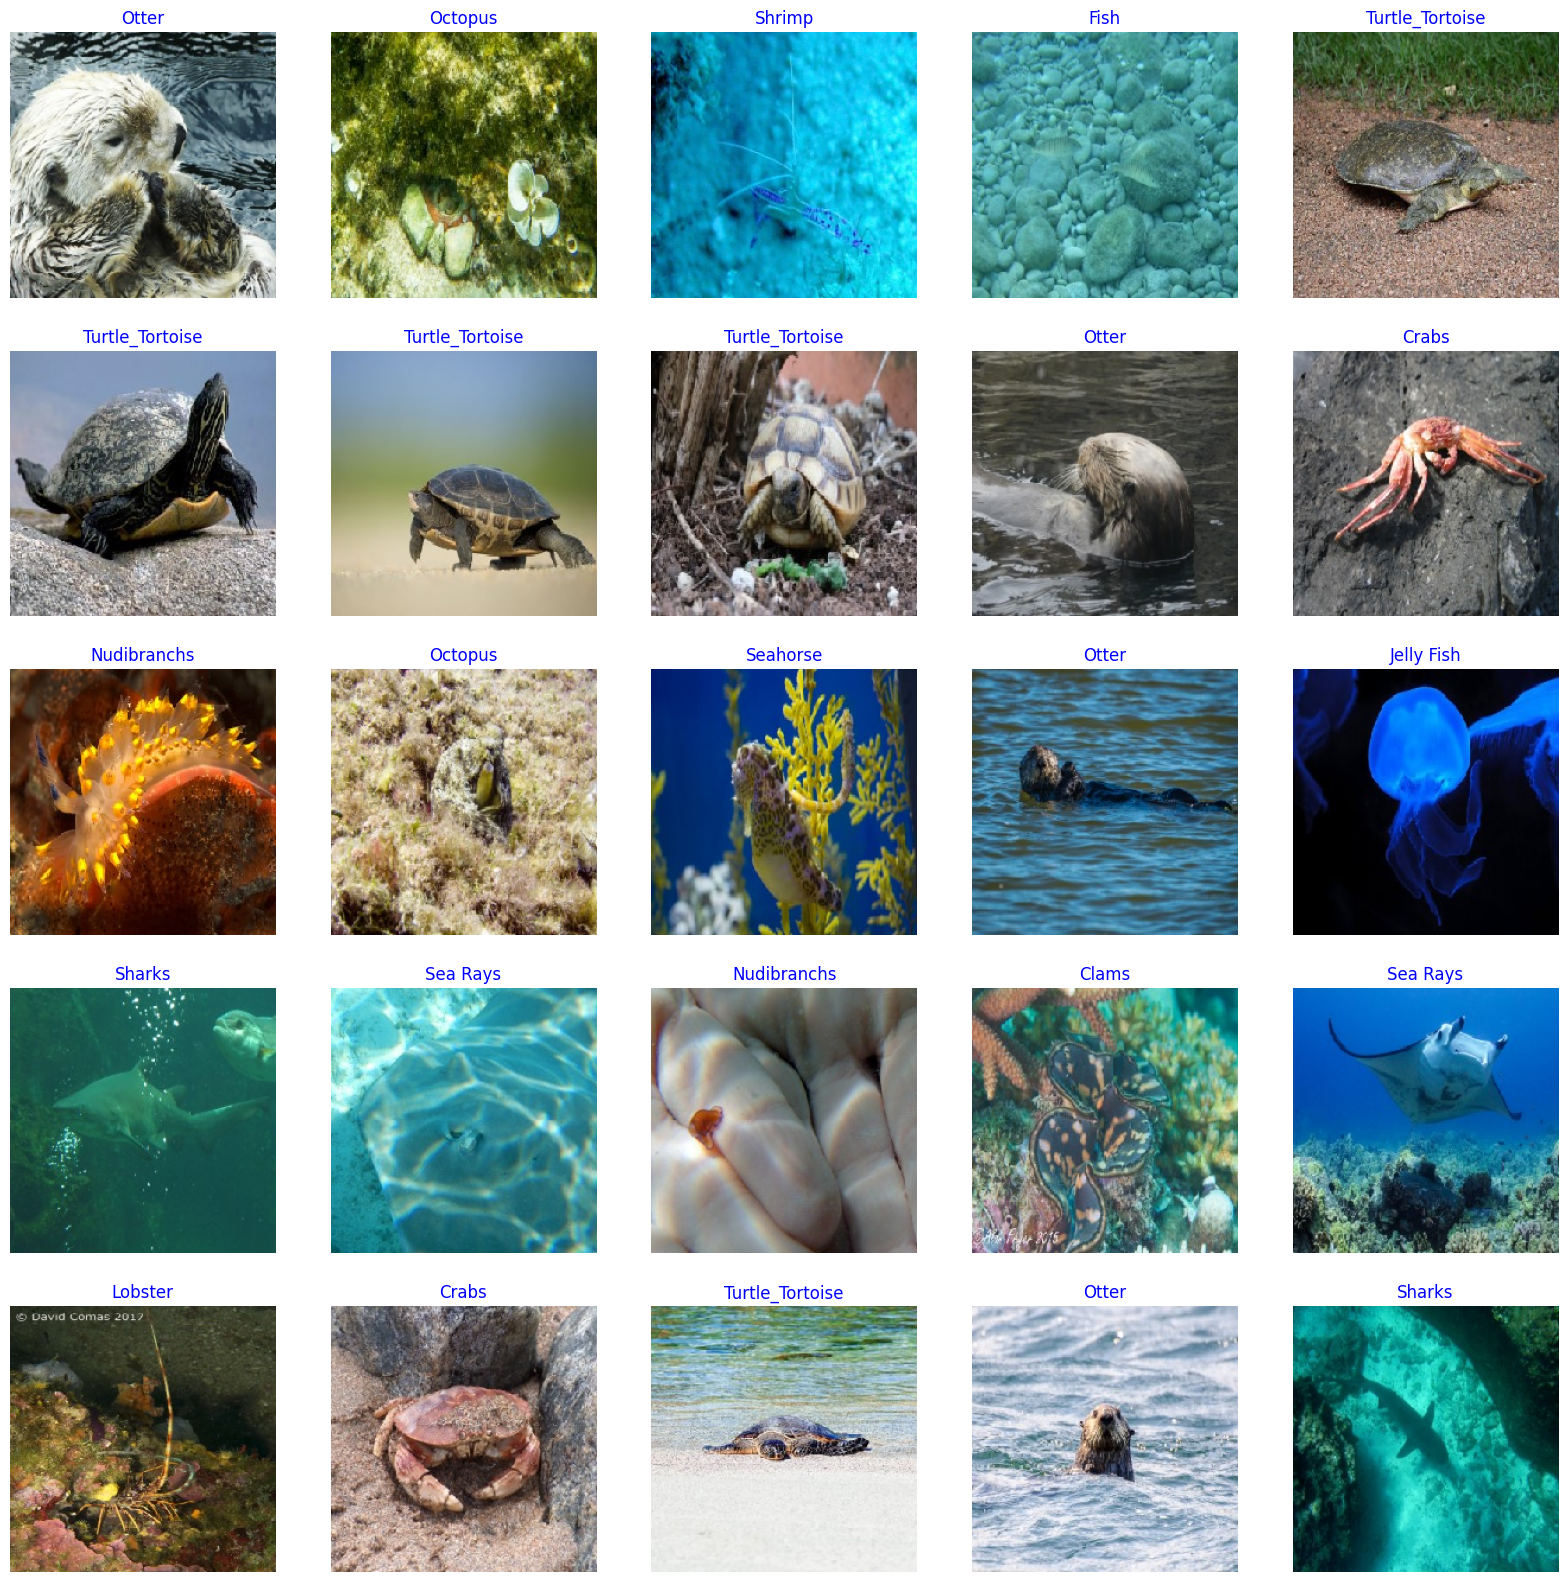

In [77]:
data_dir = './archive'

try:
    train_df, valid_df, test_df = split_data(data_dir)
    
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

show_images(train_gen)

## Image Statistics & Graphical Representation


In [13]:
classes_info = {}
for name in classes:
    classes_info[name] = len(os.listdir(folders_path + f'/{name}'))
print(classes_info)
    

{'Clams': 497, 'Corals': 500, 'Crabs': 499, 'Dolphin': 782, 'Eel': 497, 'Fish': 494, 'Jelly Fish': 845, 'Lobster': 499, 'Nudibranchs': 500, 'Octopus': 562, 'Otter': 500, 'Penguin': 482, 'Puffers': 531, 'Sea Rays': 517, 'Sea Urchins': 579, 'Seahorse': 478, 'Seal': 414, 'Sharks': 590, 'Shrimp': 488, 'Squid': 483, 'Starfish': 499, 'Turtle_Tortoise': 1903, 'Whale': 572}


In [14]:
fig = px.pie(names=classes_info.keys(),values=classes_info.values(),hole=0.05,title='CLasses Info ')
fig.update_layout({'title':{"x":0.1}})
fig.show()

 Here we can see that **Turtle tortoise** is in more numbers than other classes. So having a large no. of one class and other classes being almost equally distributed , it can cause some imbalance in our model and predictions.

In [15]:
fig = px.bar(x=classes_info.keys(),y=classes_info.values(),title='CLasses Info ')
# fig.update_layout({'title':{"x":0.1}})
fig.show()

Now from bar plot it is clear that out class **Turtle_Tortoise** is present in a large amount and can cause bias in our model and later on predictions will be more skewed towards this class. So we can drop some of its entries to balance the data for model. 

# Data Augmentation and Splitting

In [99]:
train_val_gen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip = True,
    zoom_range = 0.2,
    validation_split = 0.2
)

test_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


training_set = train_val_gen.flow_from_directory(
    folders_path,
    target_size=(200,200),
    batch_size=32,
    shuffle = True,
    class_mode= 'categorical',
    subset = 'training'
)

validation_set = train_val_gen.flow_from_directory(
    folders_path,
    target_size=(200,200),
    batch_size=32,
    shuffle = True,
    class_mode= 'categorical',
    subset = 'validation'
)

test_set = test_gen.flow_from_directory(
    folders_path,
    target_size=(200,200),
    batch_size=32,
    shuffle = True,
    class_mode= 'categorical' ,
    subset = 'validation'
)


Found 10979 images belonging to 23 classes.
Found 2732 images belonging to 23 classes.
Found 2732 images belonging to 23 classes.


Here we have augmented our data for train and validation sets.
**Training Set**  and **Validation Set** has now some fake data.

Now we will use  different **pre-trained** models for our predictions and later on will compare their results.

# Pre Trained Models 

In [17]:
from tensorflow.keras.applications import ResNet50V2,MobileNetV2 
from keras.callbacks import EarlyStopping, ModelCheckpoint

# ResNet50

In [18]:
name="ResNet50V2"

base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(256,256,3))
base_model.trainable = False

# Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256,activation='relu'),
    Dropout(0.2),
    Dense(len(classes), activation='softmax')
], name=name)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Callbacks
callbacks = [EarlyStopping(patience=5, restore_best_weights=True), ModelCheckpoint(name + ".h5", save_best_only=True)]

## Train Model


In [19]:
history1 = model.fit(training_set, epochs=10, validation_data=validation_set, callbacks=callbacks)

Epoch 1/10
344/344 [==============================] - ETA: 0s - loss: 1.2161 - accuracy: 0.6405

c:\Users\Praveen\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



344/344 [==============================] - 781s 2s/step - loss: 1.2161 - accuracy: 0.6405 - val_loss: 0.8682 - val_accuracy: 0.7376
Epoch 2/10
344/344 [==============================] - 743s 2s/step - loss: 0.8804 - accuracy: 0.7285 - val_loss: 0.8032 - val_accuracy: 0.7504
Epoch 3/10
344/344 [==============================] - 740s 2s/step - loss: 0.7846 - accuracy: 0.7578 - val_loss: 0.7650 - val_accuracy: 0.7581
Epoch 4/10
344/344 [==============================] - 713s 2s/step - loss: 0.7173 - accuracy: 0.7729 - val_loss: 0.7720 - val_accuracy: 0.7566
Epoch 5/10
344/344 [==============================] - 393s 1s/step - loss: 0.6611 - accuracy: 0.7928 - val_loss: 0.7707 - val_accuracy: 0.7646
Epoch 6/10
344/344 [==============================] - 397s 1s/step - loss: 0.6086 - accuracy: 0.8083 - val_loss: 0.7635 - val_accuracy: 0.7676
Epoch 7/10
344/344 [==============================] - 397s 1s/step - loss: 0.5875 - accuracy: 0.8105 - val_loss: 0.7470 - val_accuracy: 0.7742
Epoch 8/10

## Predict Test Set

In [20]:
resnet50v2_loss, resnet50v2_acc = model.evaluate(test_set)

86/86 [==============================] - 77s 893ms/step - loss: 0.7373 - accuracy: 0.7855


# MobileNetV2

In [21]:
name="MobileNetV2"

base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(256,256,3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256,activation='relu'),
    Dropout(0.2),
    Dense(len(classes), activation='softmax')
], name=name)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Callbacks
callbacks = [EarlyStopping(patience=5, restore_best_weights=True), ModelCheckpoint(name + ".h5", save_best_only=True)]

## Train Model


In [22]:
history2 = model.fit(training_set, epochs=10, validation_data=validation_set, callbacks=callbacks)

Epoch 1/10
344/344 [==============================] - 167s 479ms/step - loss: 1.2670 - accuracy: 0.6277 - val_loss: 0.9063 - val_accuracy: 0.7258
Epoch 2/10
344/344 [==============================] - 168s 488ms/step - loss: 0.9182 - accuracy: 0.7197 - val_loss: 0.8422 - val_accuracy: 0.7394
Epoch 3/10
344/344 [==============================] - 182s 528ms/step - loss: 0.8156 - accuracy: 0.7472 - val_loss: 0.8398 - val_accuracy: 0.7394
Epoch 4/10
344/344 [==============================] - 176s 511ms/step - loss: 0.7565 - accuracy: 0.7662 - val_loss: 0.8150 - val_accuracy: 0.7460
Epoch 5/10
344/344 [==============================] - 175s 508ms/step - loss: 0.7218 - accuracy: 0.7725 - val_loss: 0.8303 - val_accuracy: 0.7423
Epoch 6/10
344/344 [==============================] - 184s 536ms/step - loss: 0.6622 - accuracy: 0.7916 - val_loss: 0.8099 - val_accuracy: 0.7522
Epoch 7/10
344/344 [==============================] - 184s 535ms/step - loss: 0.6383 - accuracy: 0.7962 - val_loss: 0.8122 -

## Predict Test Set

In [23]:
mobileNetV2_loss, mobileNetV2_acc = model.evaluate(test_set)

86/86 [==============================] - 26s 301ms/step - loss: 0.7245 - accuracy: 0.7807


In [30]:
history_df1 = pd.DataFrame(history1.history)

history_df1.to_csv('training_history1.csv', index=False)

In [31]:
history_df2 = pd.DataFrame(history2.history)

history_df2.to_csv('training_history2.csv', index=False)

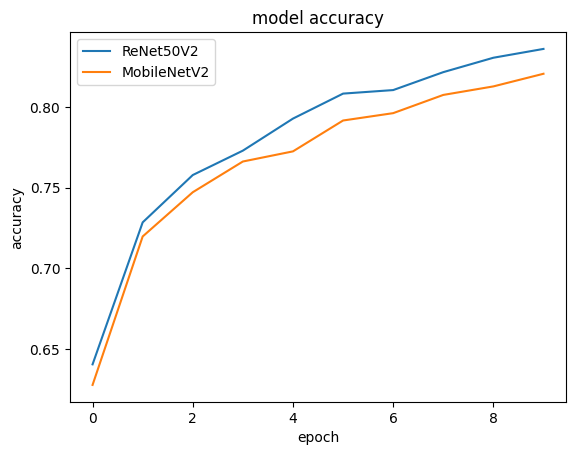

In [32]:
plt.plot(history_df1['accuracy'], label='Training Accuracy')
plt.plot(history_df2['accuracy'], label='Training Accuracy')

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['ReNet50V2', 'MobileNetV2'], loc='upper left')
plt.show()

# Modelling CNN

In [100]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Create a Sequential model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(200, 200, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(23, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 99, 99, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_7 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 48, 48, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_2 (Flatten)         (None, 147456)            0         
                                                                 
 dense_10 (Dense)            (None, 128)              

In [101]:
history4 =model.fit(training_set, epochs=10, validation_data=validation_set)

Epoch 1/10


c:\Users\Praveen\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



344/344 [==============================] - 376s 1s/step - loss: 2.7282 - accuracy: 0.2325 - val_loss: 2.2899 - val_accuracy: 0.3148
Epoch 2/10
344/344 [==============================] - 346s 1s/step - loss: 2.3124 - accuracy: 0.3069 - val_loss: 2.1402 - val_accuracy: 0.3664
Epoch 3/10
344/344 [==============================] - 357s 1s/step - loss: 2.1758 - accuracy: 0.3436 - val_loss: 2.0712 - val_accuracy: 0.3730
Epoch 4/10
344/344 [==============================] - 348s 1s/step - loss: 2.0696 - accuracy: 0.3715 - val_loss: 1.9977 - val_accuracy: 0.3971
Epoch 5/10
344/344 [==============================] - 356s 1s/step - loss: 1.9825 - accuracy: 0.3977 - val_loss: 1.9853 - val_accuracy: 0.3979
Epoch 6/10
344/344 [==============================] - 357s 1s/step - loss: 1.9071 - accuracy: 0.4137 - val_loss: 1.9078 - val_accuracy: 0.4242
Epoch 7/10
344/344 [==============================] - 359s 1s/step - loss: 1.8250 - accuracy: 0.4448 - val_loss: 1.8421 - val_accuracy: 0.4264
Epoch 8/10

In [102]:
history_df4 = pd.DataFrame(history4.history)
history_df4.to_csv('training_history4.csv', index=False)

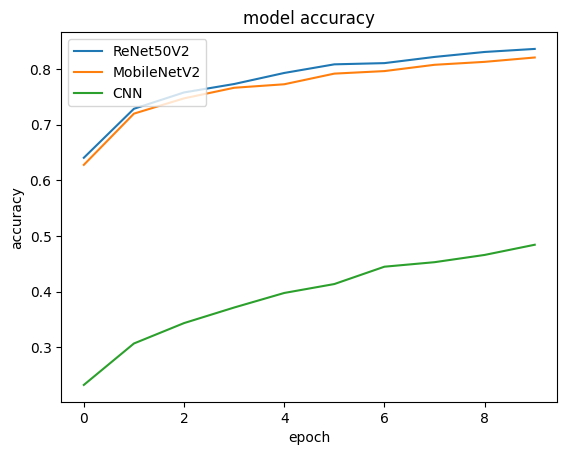

In [105]:
plt.plot(history_df1['accuracy'], label='Training Accuracy')
plt.plot(history_df2['accuracy'], label='Training Accuracy')
plt.plot(history_df4['accuracy'], label='Training Accuracy')

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['ReNet50V2', 'MobileNetV2', 'CNN'], loc='upper left')
plt.show()